# [作業目標]
- 使用 Day 17 剛學到的方法, 對較完整的資料生成離散化特徵
- 觀察上述離散化特徵, 對於目標值的預測有沒有幫助

# [作業重點]
- 仿照 Day 17 的語法, 將年齡資料 ('DAYS_BIRTH' 除以 365) 離散化
- 繪製上述的 "離散化標籤" 與目標值 ('TARGET') 的長條圖

In [1]:
# 載入需要的套件
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
%matplotlib inline

# 設定 data_path
dir_data = '../data/'

### 之前做過的處理

In [2]:
# 讀取資料檔
f_app_train = os.path.join(dir_data, 'application_train.csv')
app_train = pd.read_csv(f_app_train)
app_train.shape

(307511, 122)

In [3]:
# 將只有兩種值的類別型欄位, 做 Label Encoder, 計算相關係數時讓這些欄位可以被包含在內
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# 檢查每一個 column
for col in app_train:
    if app_train[col].dtype == 'object':
        # 如果只有兩種值的類別型欄位
        if len(list(app_train[col].unique())) <= 2:
            # 就做 Label Encoder, 以加入相關係數檢查
            app_train[col] = le.fit_transform(app_train[col])            
print(app_train.shape)
app_train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,M,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,F,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,M,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,F,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,M,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# 受雇日數為異常值的資料, 另外設一個欄位記錄, 並將異常的日數轉成空值 (np.nan)
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# 出生日數 (DAYS_BIRTH) 取絕對值 
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])

## 練習時間
參考 Day 17 範例程式，離散化你覺得有興趣的欄位，並嘗試找出有趣的訊息

In [5]:
app_train['YEARS_BIRTH_Range'] = pd.cut(app_train['DAYS_BIRTH'] / 365, bins=[20,30,40,50,60,70], 
                                        labels=['20-30','30-40','40-50','50-60','60-70'])
app_train['YEARS_BIRTH_Range'].value_counts()

30-40    82308
40-50    76541
50-60    68062
20-30    45021
60-70    35579
Name: YEARS_BIRTH_Range, dtype: int64

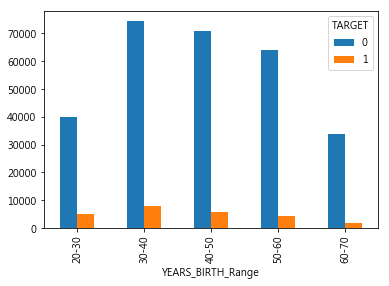

In [6]:
pd.crosstab(app_train['YEARS_BIRTH_Range'],app_train['TARGET']).plot(kind='bar')
plt.show()

In [7]:
train_X = app_train[['DAYS_BIRTH','CNT_CHILDREN']].copy()
train_X['DAYS_BIRTH'] = train_X['DAYS_BIRTH'] / 365
train_Y = app_train['TARGET']
estimator = LogisticRegression(solver='lbfgs')
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.9192711805397202

In [8]:
train_X_dis = app_train[['YEARS_BIRTH_Range', 'CNT_CHILDREN']].copy()
train_X_dis.replace({'YEARS_BIRTH_Range': {'20-30':0,
                                           '30-40':1,
                                           '40-50':2,
                                           '50-60':3,
                                           '60-70':4}}, inplace=True)
train_Y = app_train['TARGET']
estimator = LogisticRegression(solver='lbfgs')
cross_val_score(estimator, train_X_dis, train_Y, cv=5).mean()

0.9192711805397202

* 使用 Logistic Regression 做驗證，離散化後雖然預測準確率沒有提升，但訓練的執行速度方面有變快